# Coronagraph inpainting model

## Data downloading and preprocessing

!python3 data.py

In [1]:
from utils import get_default_device
device = get_default_device()
print(device)

cuda


In [2]:
import torch
torch.cuda.empty_cache()

## Creating dataset

In [3]:
batch_size = 1

In [4]:
from torch.utils.data import random_split, DataLoader
from utils import DeviceDataLoader
from data import CoronagraphDataset, CrossDataset

dataset = CoronagraphDataset('c3')
# 0.8 - 0.2
train_len = round(0.8*len(dataset))
val_len = len(dataset) - train_len

#random split
train_ds, val_ds = random_split(dataset, [train_len, val_len])

train_dl = DeviceDataLoader(DataLoader(train_ds, batch_size, True, num_workers = 4, pin_memory=True), device)
val_dl = DeviceDataLoader(DataLoader(val_ds, batch_size, True, num_workers = 4, pin_memory=True), device)

/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
import torch
from utils import to_device
sample_tensor = (torch.randn(1,1,1024,1024).to(device), torch.ones(1,1,1024,1024).to(device))

In [6]:
from model import SmallUNet, FourierModel
from loss import NewInpaintingLoss

model = to_device(FourierModel('Fourier', NewInpaintingLoss([6, 6, 0.5, 1.2, 1.8, 0.7])), device)

1. Fourier_0.pt


Validation - Epoch: 0: 100%|██████████| 165/165 [00:31<00:00,  5.16it/s]


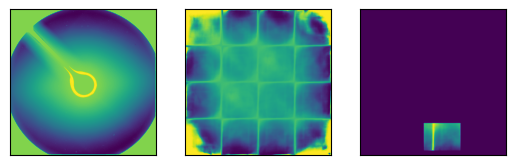

Training - Epoch: 1:   0%|          | 0/658 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacty of 11.72 GiB of which 82.06 MiB is free. Including non-PyTorch memory, this process has 11.30 GiB memory in use. Of the allocated memory 10.58 GiB is allocated by PyTorch, and 514.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import Adam, SGD, RMSprop
model.fit(
    train_dl,
    val_dl,
    epochs = 25,
    lr = 1e-2,
    batch_size = batch_size,
    weight_decay = 0,
    grad_clip = False,
    opt_func = Adam,
    lr_sched = OneCycleLR,
    saving_div = 25,
)